In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

In [2]:
import json
import os
import pickle
import re
import time

import matplotlib.pyplot as plt
from plotnine import *
import pandas as pd
import numpy as np

import tensorflow as tf
print("TensorFlow version: {}".format(tf.VERSION))

import tflearn

# flare-ai imports
from utils import featurize_utils, plot_utils

//anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
//anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow version: 1.7.0
Instructions for updating:
Use the retry module or similar alternatives.


# Load Data

Data generation is now exported to `featurize_gamestate.py`

In [3]:
game_state_dir = '/Users/lpekelis/flare/flare-ai/data/'
os.listdir(game_state_dir)

['game_states_20180611_002848.p', 'game_states_features_20180611_002848.h5']

In [5]:
game_state_store = pd.HDFStore(game_state_dir + 'game_states_features_20180611_002848.h5')
print(game_state_store)
X = game_state_store.get('X')
y = game_state_store.get('y')
y_entity_damage = game_state_store.get('y_entity_damage')


<class 'pandas.io.pytables.HDFStore'>
File path: /Users/lpekelis/flare/flare-ai/data/game_states_features_20180611_002848.h5



In [7]:
with open(game_state_dir + 'game_states_20180611_002848.p', 'rb') as f:
    game_states = pickle.load(f)

# Diagnostics

In [8]:
collision_layer = featurize_utils.load_collision_layer()

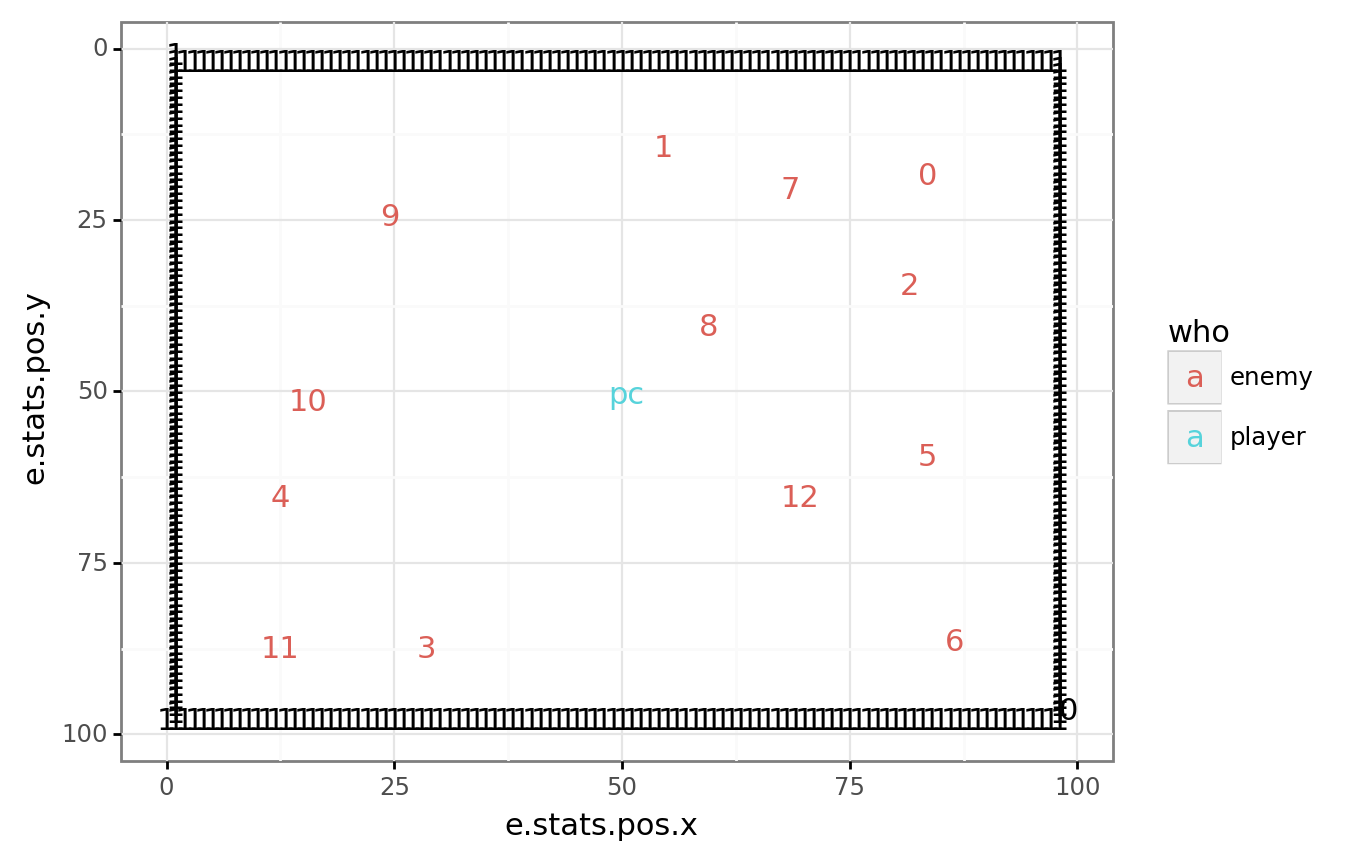

<ggplot: (333006733)>

In [9]:
plot_utils.plot_state(game_states[0], [collision_layer], ['black'])

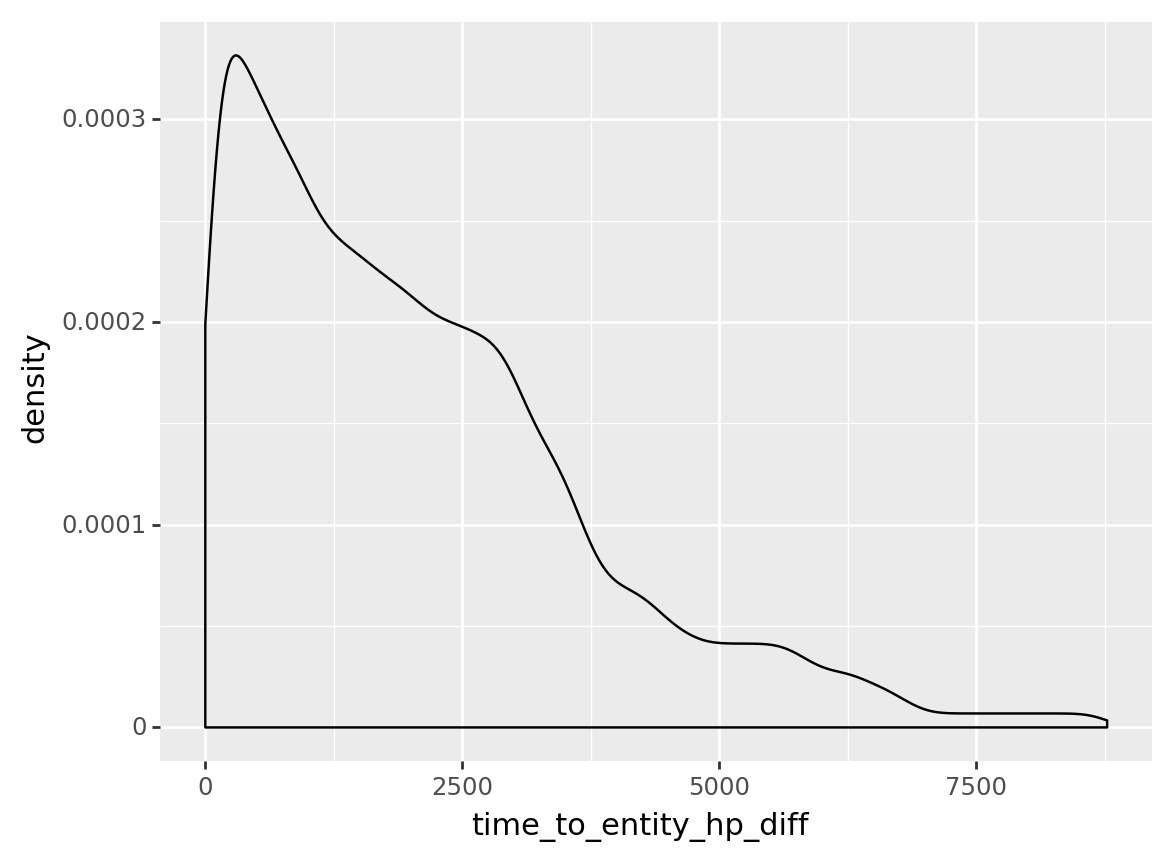

<ggplot: (-9223372036520524849)>

In [11]:
(
    ggplot(y, aes(x='time_to_entity_hp_diff')) 
    + geom_density()
)

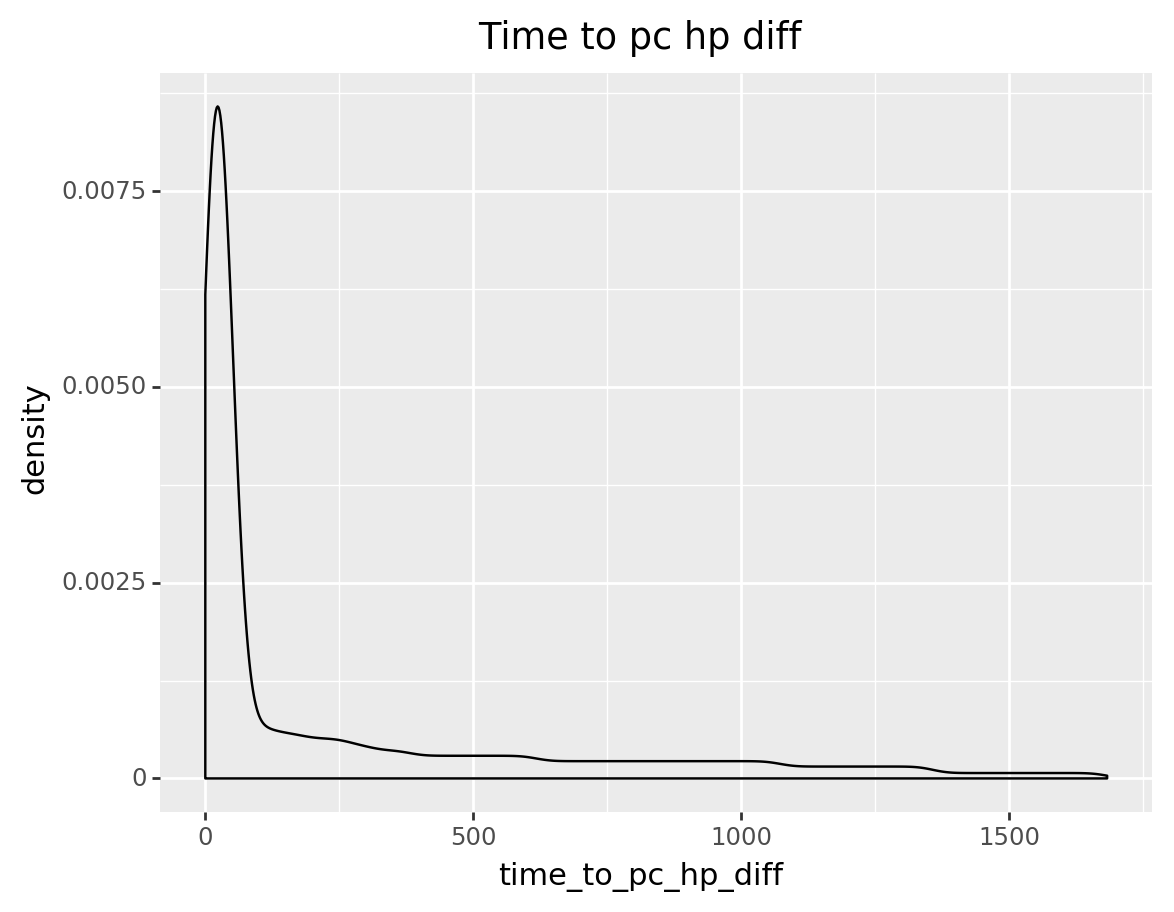

<ggplot: (315701624)>

In [12]:
(
    ggplot(y, aes(x='time_to_pc_hp_diff')) 
    + geom_density()
    + ggtitle('Time to pc hp diff')
)

# Load model

In [13]:
# Build neural network
net = tflearn.input_data(shape=[None, 108])
net = tflearn.fully_connected(net, 64, activation='relu')
net = tflearn.fully_connected(net, 32)
net = tflearn.fully_connected(net, 32, activation='relu')
net = tflearn.fully_connected(net, 16, activation='relu')
net = tflearn.fully_connected(net, 2, activation='softmax')
net = tflearn.regression(net)

# Define model
model = tflearn.DNN(net)

MODEL_DIR = '/Users/lpekelis/flare/flare-ai/models/'

model.load(MODEL_DIR + 'median_time_to_damage_20180611_003221.tflearn')

Instructions for updating:
keep_dims is deprecated, use keepdims instead
INFO:tensorflow:Restoring parameters from /Users/lpekelis/flare/flare-ai/models/median_time_to_damage_20180611_003221.tflearn


# Predict

In [14]:
pred = pd.DataFrame(
    model.predict(
        np.array(X, dtype=np.float32)
    )
)

In [15]:
pred.describe()

,0,1
count,1.451300e+05,145130.000000
mean,5.086237e-01,0.491320
std,2.486050e-01,0.248607
min,9.111615e-28,0.000000
25%,5.323826e-01,0.467617
50%,5.323826e-01,0.467617
75%,5.323826e-01,0.467617
max,1.000000e+00,1.000000


In [47]:
least_safe_idxs = pred.sort_values(0).head().index.values
safest_idxs = pred.sort_values(0,ascending=False).head().index.values

## Least Safe Positions

e.stats.hp        7.000000
e.stats.mp        0.000000
e.stats.pos.x    73.934914
e.stats.pos.y    61.545353
pc.stats.hp       0.000000
pc.stats.mp      10.000000
e.pc.dx           0.622230
e.pc.dy          -4.647373
Name: (9383, 2), dtype: float64

is_entity_alive                       1.0
entity_hp                             7.0
pc_hp                                 0.0
entity_hp_diff                        0.0
pc_hp_diff                            0.0
time_to_entity_hp_diff              309.0
time_above_median_entity_hp_diff      0.0
time_to_pc_hp_diff                    7.0
time_above_median_pc_hp_diff          0.0
Name: (9383, 2), dtype: float64

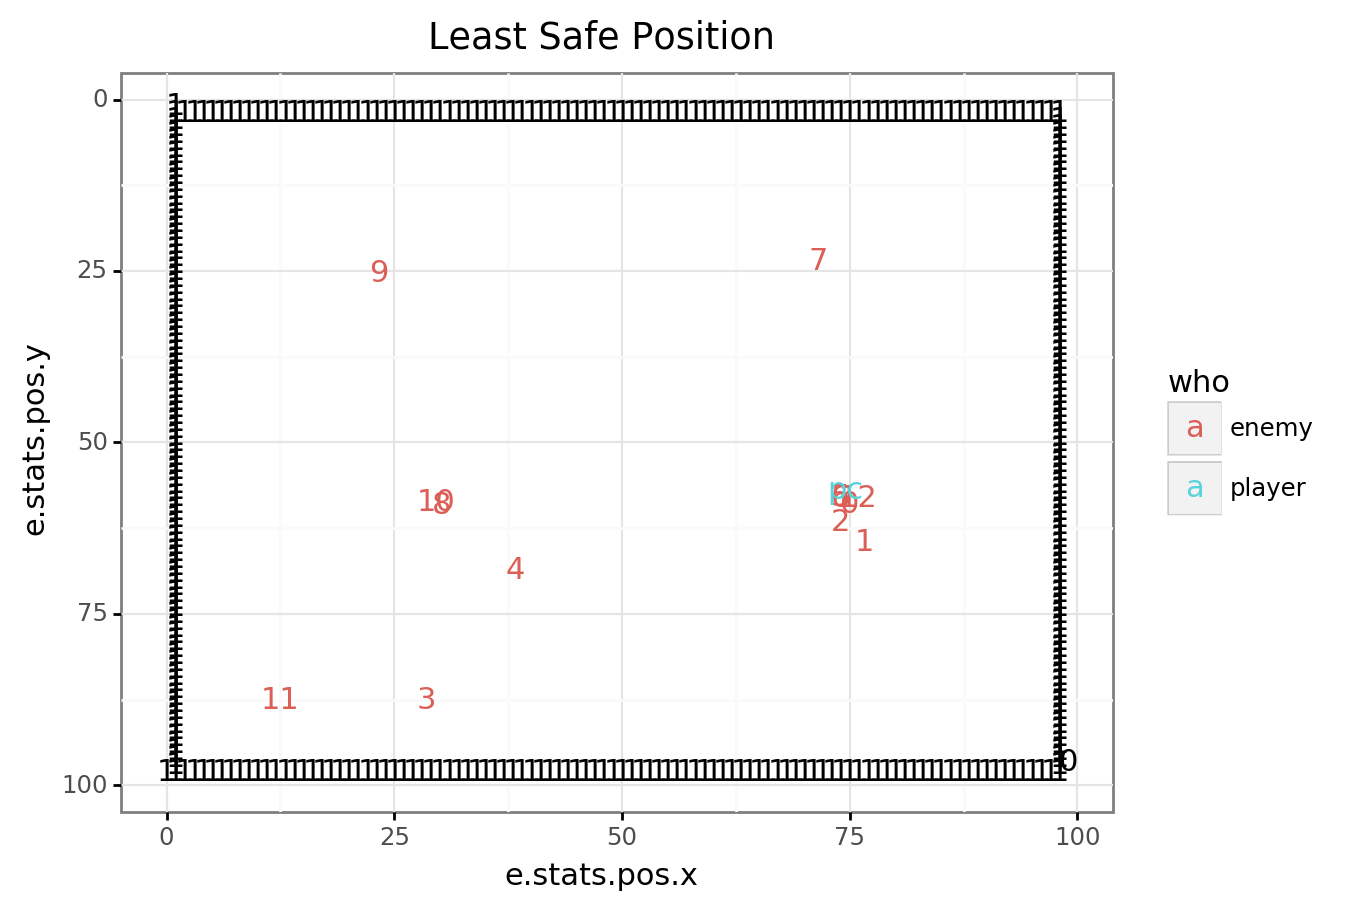

<ggplot: (316982648)>

In [42]:
display(X.iloc[least_safe_idxs[0],0:8])
display(y.iloc[least_safe_idxs[0],:])
(
    plot_utils.plot_state(game_states[X.index.values[least_safe_idxs[0]][0]],[collision_layer],['black'])
    + ggtitle('Least Safe Position')
)

e.stats.hp       50.000000
e.stats.mp        0.000000
e.stats.pos.x    76.086693
e.stats.pos.y    59.590431
pc.stats.hp       0.000000
pc.stats.mp      10.000000
e.pc.dx          -1.529549
e.pc.dy          -2.692451
Name: (9412, 12), dtype: float64

is_entity_alive                       1.0
entity_hp                            50.0
pc_hp                                 0.0
entity_hp_diff                        0.0
pc_hp_diff                            0.0
time_to_entity_hp_diff              518.0
time_above_median_entity_hp_diff      0.0
time_to_pc_hp_diff                   49.0
time_above_median_pc_hp_diff          1.0
Name: (9412, 12), dtype: float64

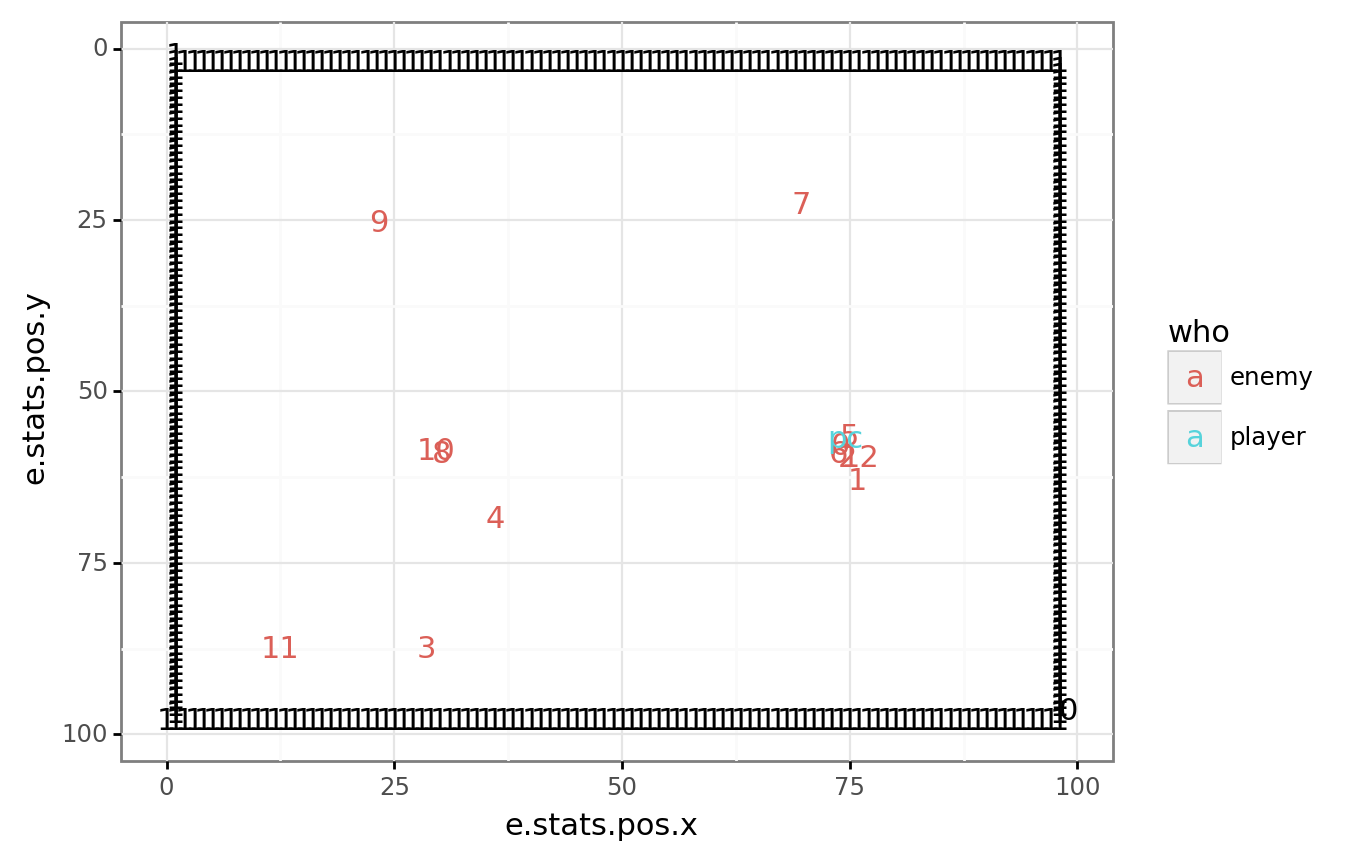

<ggplot: (-9223372036537472473)>

In [44]:
display(X.iloc[least_safe_idxs[1],0:8])
display(y.iloc[least_safe_idxs[1],:])
(
    plot_utils.plot_state(game_states[X.index.values[least_safe_idxs[1]][0]],[collision_layer],['black'])
)

e.stats.hp        7.000000
e.stats.mp        0.000000
e.stats.pos.x    74.359169
e.stats.pos.y    61.121098
pc.stats.hp       0.000000
pc.stats.mp      10.000000
e.pc.dx           0.197975
e.pc.dy          -4.223118
Name: (9391, 2), dtype: float64

is_entity_alive                       1.0
entity_hp                             7.0
pc_hp                                 0.0
entity_hp_diff                        0.0
pc_hp_diff                            0.0
time_to_entity_hp_diff              205.0
time_above_median_entity_hp_diff      0.0
time_to_pc_hp_diff                    3.0
time_above_median_pc_hp_diff          0.0
Name: (9391, 2), dtype: float64

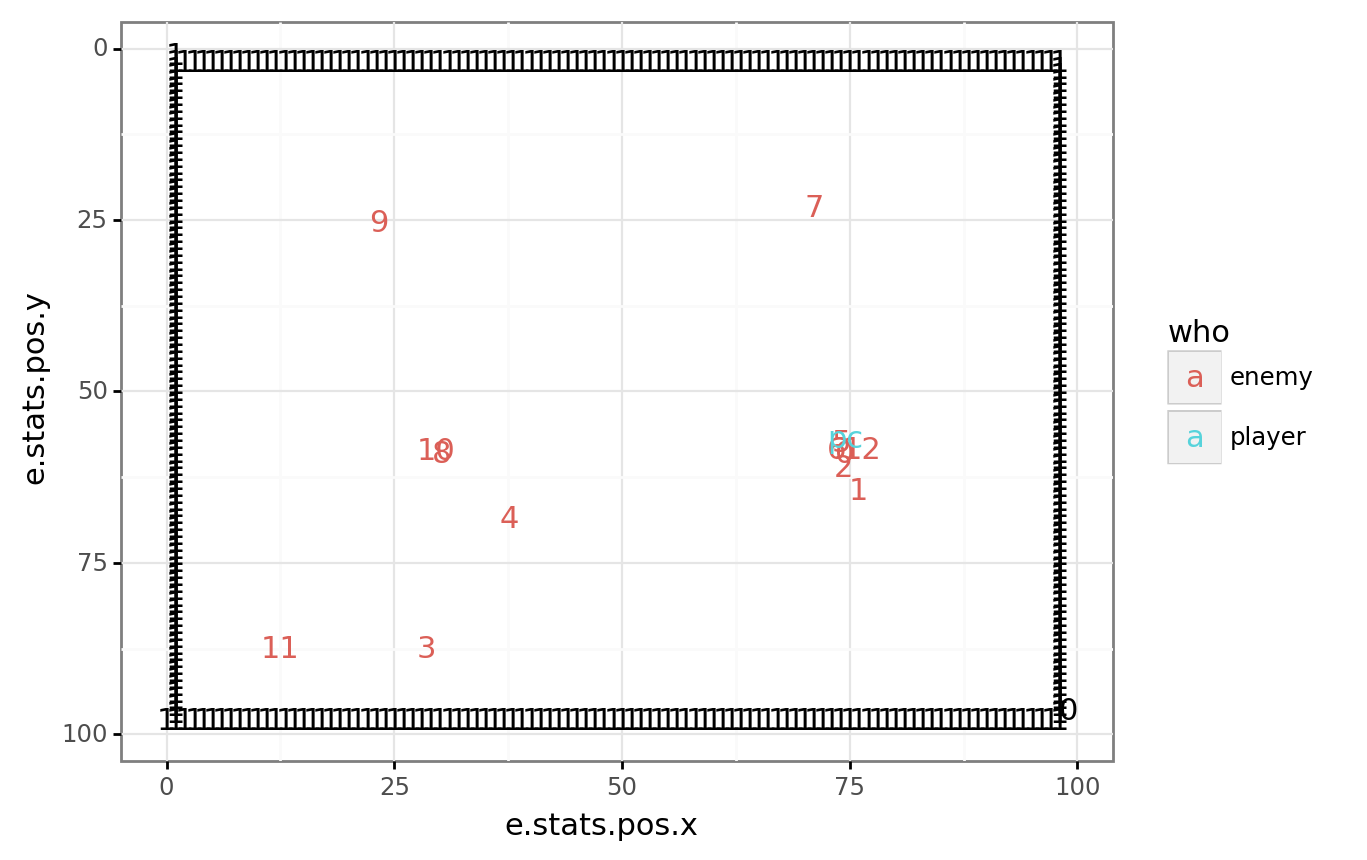

<ggplot: (317304342)>

In [45]:
display(X.iloc[least_safe_idxs[2],0:8])
display(y.iloc[least_safe_idxs[2],:])
(
    plot_utils.plot_state(game_states[X.index.values[least_safe_idxs[2]][0]],[collision_layer],['black'])
)

## Most Safe Positions

e.stats.hp       50.000000
e.stats.mp        0.000000
e.stats.pos.x    73.594193
e.stats.pos.y    61.895908
pc.stats.hp       0.000000
pc.stats.mp      10.000000
e.pc.dx           0.962951
e.pc.dy          -4.997928
Name: (9466, 12), dtype: float64

is_entity_alive                        1.0
entity_hp                             50.0
pc_hp                                  0.0
entity_hp_diff                         0.0
pc_hp_diff                             0.0
time_to_entity_hp_diff              3851.0
time_above_median_entity_hp_diff       1.0
time_to_pc_hp_diff                    10.0
time_above_median_pc_hp_diff           0.0
Name: (9466, 12), dtype: float64

0    1.000000e+00
1    2.113618e-08
Name: 105147, dtype: float32

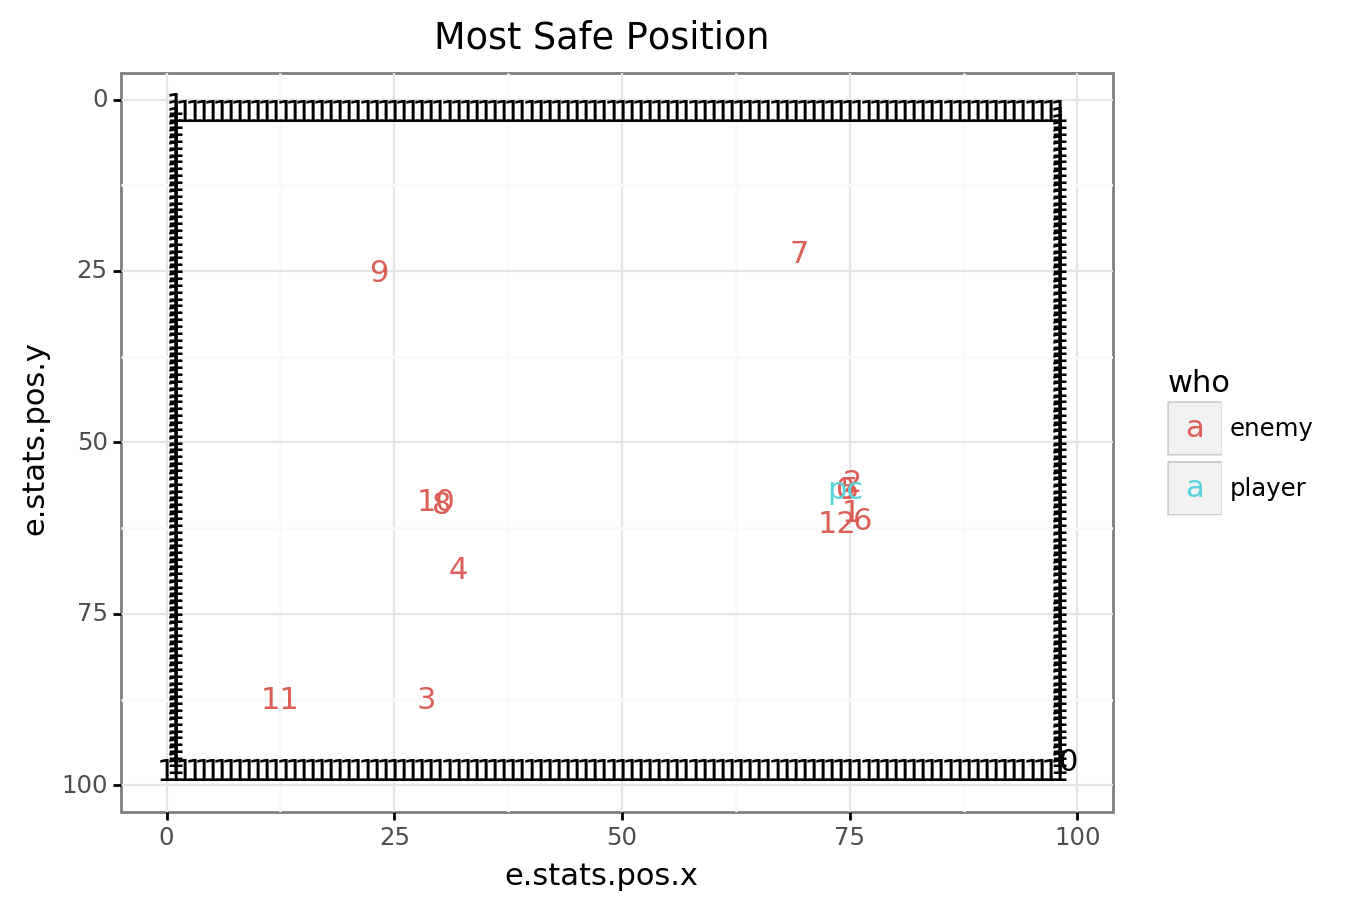

<ggplot: (334962240)>

In [50]:
display(
    X.iloc[safest_idxs[0],0:8], 
    y.iloc[safest_idxs[0],:],
    pred.iloc[safest_idxs[0],:]
)

(
    plot_utils.plot_state(game_states[X.index.values[safest_idxs[0]][0]],[collision_layer],['black'])
    + ggtitle('Most Safe Position')
)

e.stats.hp        7.000000
e.stats.mp        0.000000
e.stats.pos.x    75.006836
e.stats.pos.y    71.621170
pc.stats.hp      23.000000
pc.stats.mp      10.000000
e.pc.dx           1.393776
e.pc.dy          -8.583939
Name: (9181, 2), dtype: float64

is_entity_alive                        1.0
entity_hp                              7.0
pc_hp                                 23.0
entity_hp_diff                         0.0
pc_hp_diff                             0.0
time_to_entity_hp_diff              2935.0
time_above_median_entity_hp_diff       1.0
time_to_pc_hp_diff                     1.0
time_above_median_pc_hp_diff           0.0
Name: (9181, 2), dtype: float64

0    1.000000e+00
1    1.103176e-10
Name: 101433, dtype: float32

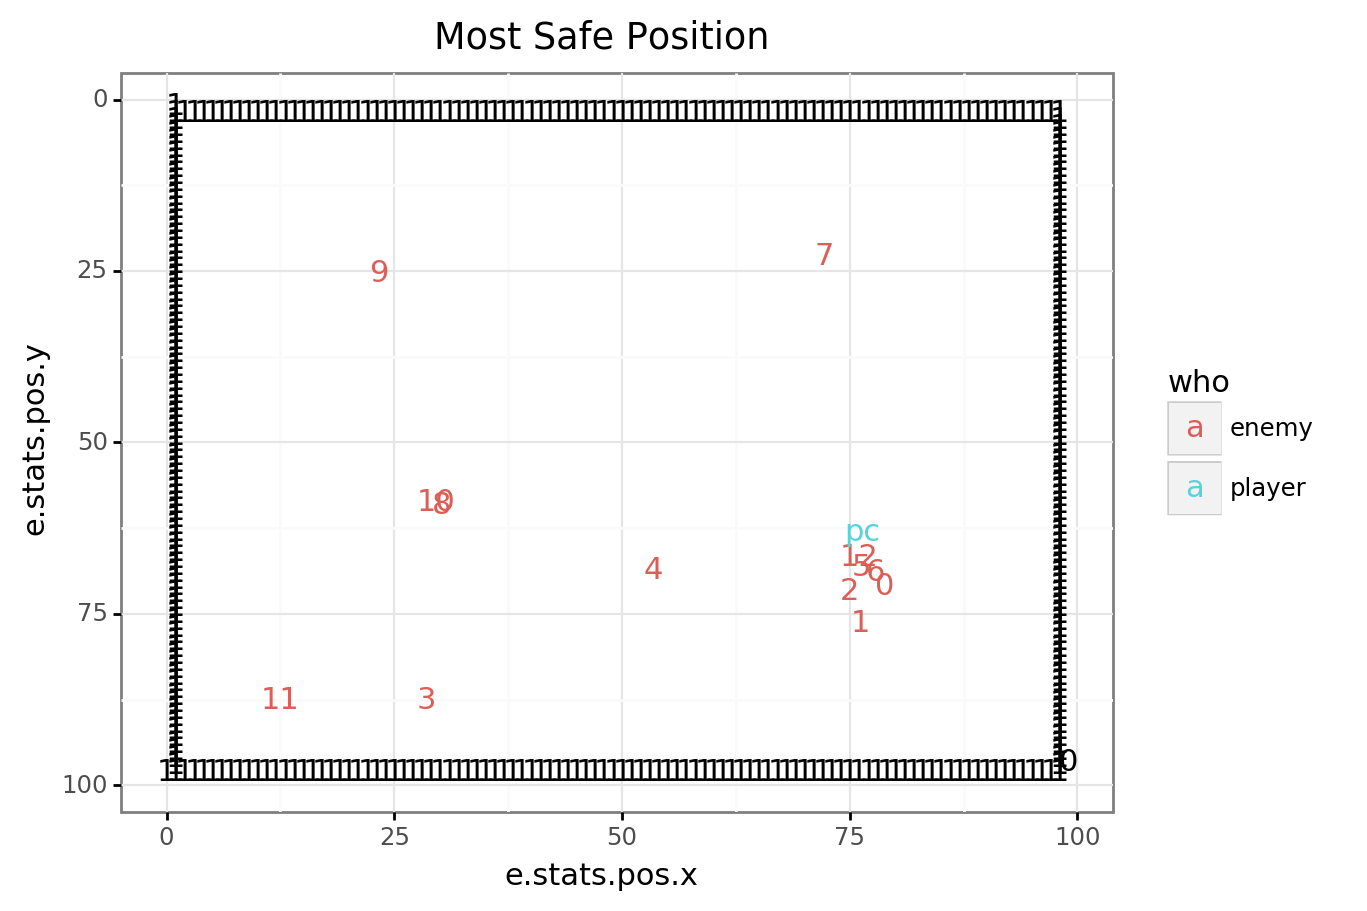

<ggplot: (-9223372036522966198)>

In [52]:
display(
    X.iloc[safest_idxs[1],0:8], 
    y.iloc[safest_idxs[1],:],
    pred.iloc[safest_idxs[1],:]
)

(
    plot_utils.plot_state(game_states[X.index.values[safest_idxs[1]][0]],[collision_layer],['black'])
    + ggtitle('Most Safe Position')
)

e.stats.hp       50.000000
e.stats.mp        0.000000
e.stats.pos.x    83.628845
e.stats.pos.y    38.677338
pc.stats.hp      90.000000
pc.stats.mp      10.000000
e.pc.dx          -3.075302
e.pc.dy           2.926136
Name: (7980, 7), dtype: float64

is_entity_alive                        1.0
entity_hp                             50.0
pc_hp                                 90.0
entity_hp_diff                         0.0
pc_hp_diff                             0.0
time_to_entity_hp_diff              2691.0
time_above_median_entity_hp_diff       1.0
time_to_pc_hp_diff                   319.0
time_above_median_pc_hp_diff           1.0
Name: (7980, 7), dtype: float64

0    1.000000e+00
1    1.655589e-10
Name: 85826, dtype: float32

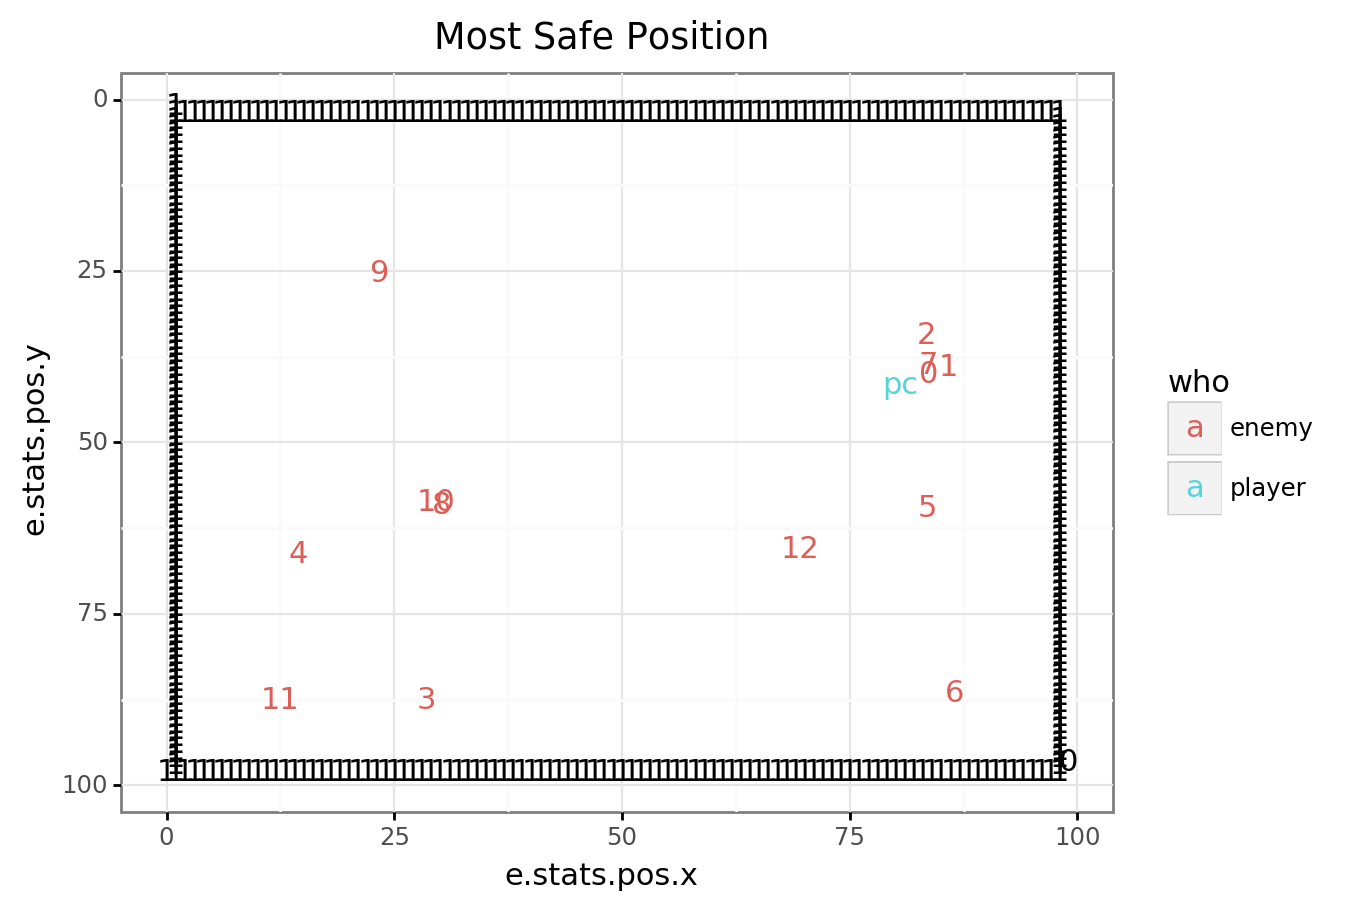

<ggplot: (-9223372036522985735)>

In [51]:
display(
    X.iloc[safest_idxs[2],0:8], 
    y.iloc[safest_idxs[2],:],
    pred.iloc[safest_idxs[2],:]
)

(
    plot_utils.plot_state(game_states[X.index.values[safest_idxs[2]][0]],[collision_layer],['black'])
    + ggtitle('Most Safe Position')
)